<a href="https://colab.research.google.com/github/JongHoB/Data_Mining_Spark_WordCount/blob/main/Colab_1_Wordcount_in_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wordcount in Spark

This Colab, adopted for Ajou CSE3313, is from [Stanford CS246](http://cs246.stanford.edu).

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=e84aab196ad98176d52689bee997449f0ba33f00c1c1d6761db0183b7b693ecc
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 17 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected packag

Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id='16hCaOa3Vx1WiwpYZsm0hHog8zv3goIHZ'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('pg100.txt')

If you executed the cells above, you should be able to see the file *pg100.txt* under the "Files" tab on the left panel.

### Your task

If you run successfully the setup stage, you are ready to work on the *pg100.txt* file which contains a copy of the complete works of Shakespeare.

Write a Spark application which outputs the number of words that start with each letter. This means that for every letter we want to count the total number of (non-unique) words that start with a specific letter.

In your implementation, **ignore the letter case**, i.e., consider all words as lower case. Also, you can ignore all words that **start** with a non-alphabetic character. You should output word counts for the **entire document**, inclusive of the title, author, and the main texts. If you encounter words broken as a result of new lines, e.g. "pro-ject" where the segment after the dash sign is on a new line, no special processing is needed and you can safely consider it as two words.

Output: 1. Two column matrix with alphabet in the first column and wordcount in the second colum. 2. Optionally, use the matrix to plot a bargraph of x-axis alphabet, y-axis the wordcount.

In [4]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
# SparkContext is the entry point to any spark functionality.
# SparkConf provides configurations to run a Spark application.
from pyspark import SparkContext, SparkConf


# create the Spark Session
spark = SparkSession.builder.appName("WordCount").getOrCreate()

# create the Spark Context
sc = spark.sparkContext

In [5]:
# YOUR
txt = spark.read.text('pg100.txt')

In [95]:
# CODE
rdd=txt.rdd.map(lambda row: row.value.lower()).flatMap(lambda x: x.split(" "))
rdd=rdd.map(lambda x: x.replace(")","-").replace(",",'-').replace(".",'-').replace("?","-").replace("!","-")).flatMap(lambda x: x.split("-"))
rdd1=rdd.filter(lambda row: row!='' and row[0].isalpha())
rdd2=rdd1.map(lambda x: (x[0],1))
rdd3=rdd2.reduceByKey(lambda a,b: a+b).sortBy(lambda x: x[0])
schema=rdd3.map(lambda x: Row(alphabet=x[0],count=x[1]))
table=spark.createDataFrame(schema)
table_pd=table.toPandas()

In [96]:
# HERE
rdd1.count()

900869

In [97]:
table.show(26)

+--------+------+
|alphabet| count|
+--------+------+
|       a| 85090|
|       b| 45862|
|       c| 34799|
|       d| 30088|
|       e| 19059|
|       f| 37074|
|       g| 20922|
|       h| 60842|
|       i| 62280|
|       j|  3357|
|       k|  9462|
|       l| 29803|
|       m| 56119|
|       n| 26970|
|       o| 43609|
|       p| 27952|
|       q|  2387|
|       r| 14372|
|       s| 66077|
|       t|123928|
|       u|  9209|
|       v|  5783|
|       w| 59847|
|       x|    14|
|       y| 25892|
|       z|    72|
+--------+------+



Text(0.5, 1.0, 'Word Count')

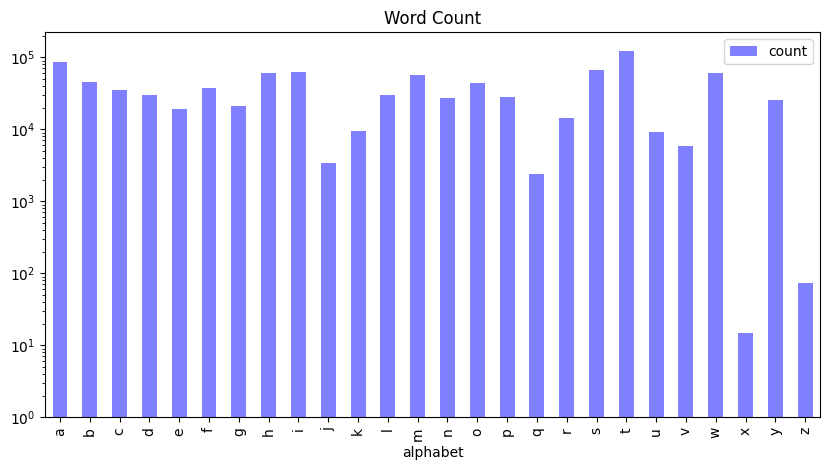

In [98]:
pl=table_pd.plot(kind="bar",x="alphabet",y="count",figsize=(10,5),log=True,alpha=0.5,color="blue")
pl.set_title('Word Count')